In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib as plt


## 1. Carga de datos

In [2]:
df = pd.read_csv(r"C:\Users\basti\OneDrive\Escritorio\Datasets\nyc_taxi_sample.csv")

## 2. Limpieza y preprocesamiento de los datos

Antes de entrenar cualquier modelo, es fundamental entender y preparar bien los datos. En esta secci√≥n se revisa el estado inicial del dataset y se aplican transformaciones clave.

### 2.1 Revisi√≥n inicial del DataFrame
Se utiliza `df.info()` para conocer:
- El n√∫mero total de filas y columnas.
- El tipo de datos de cada columna.
- La cantidad de valores no nulos por variable.

Esto permite identificar r√°pidamente columnas con datos faltantes, como:
- `passenger_count`
- `RatecodeID`
- `congestion_surcharge`
- `Airport_fee`

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               500000 non-null  int64  
 1   tpep_pickup_datetime   500000 non-null  object 
 2   tpep_dropoff_datetime  500000 non-null  object 
 3   passenger_count        486188 non-null  float64
 4   trip_distance          500000 non-null  float64
 5   RatecodeID             486188 non-null  float64
 6   PULocationID           500000 non-null  int64  
 7   DOLocationID           500000 non-null  int64  
 8   payment_type           500000 non-null  int64  
 9   fare_amount            500000 non-null  float64
 10  extra                  500000 non-null  float64
 11  mta_tax                500000 non-null  float64
 12  tip_amount             500000 non-null  float64
 13  tolls_amount           500000 non-null  float64
 14  improvement_surcharge  500000 non-nu

### 2.2 Ingenier√≠a de caracter√≠sticas
Se crean nuevas columnas a partir de `tpep_pickup_datetime`:

- `pickup_hour`: Hora en la que inicia el viaje.
- `dayWeek`: D√≠a de la semana (0 = lunes, 6 = domingo).
- `is_weekend`: Indica si el viaje fue s√°bado o domingo.
- `isnight`: Bandera que indica si el viaje fue de noche (entre las 22:00 y las 6:00).
- `is_airport_trip`: Marca si el viaje incluy√≥ un cargo de aeropuerto.

In [4]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['dayWeek'] = df['tpep_pickup_datetime'].dt.dayofweek
df['is_weekend'] = df['dayWeekend'].isin([5, 6]).astype(int)
def esNoche(hora):
    return (hora >=22) | (hora <=6)
df['isnight'] = df['pickup_hour'].apply(esNoche).astype(int)
df['is_airport_trip'] = (df['Airport_fee']>0).astype(int)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               500000 non-null  int64         
 1   tpep_pickup_datetime   500000 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  500000 non-null  object        
 3   passenger_count        486188 non-null  float64       
 4   trip_distance          500000 non-null  float64       
 5   RatecodeID             486188 non-null  float64       
 6   PULocationID           500000 non-null  int64         
 7   DOLocationID           500000 non-null  int64         
 8   payment_type           500000 non-null  int64         
 9   fare_amount            500000 non-null  float64       
 10  extra                  500000 non-null  float64       
 11  mta_tax                500000 non-null  float64       
 12  tip_amount             500000 non-null  floa

In [6]:
cols_to_drop = [
    "VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime", "payment_type",
    "total_amount", "extra", "mta_tax", "tip_amount", "tolls_amount",
    "improvement_surcharge", "congestion_surcharge", "Airport_fee",
     "dayWeekend"
]
df = df.drop(columns=cols_to_drop)

In [7]:
df[['passenger_count','RatecodeID']].isnull().sum()
mode_passenger = df['passenger_count'].mode()[0]
df['passenger_count'] = df['passenger_count'].fillna(mode_passenger)
RatecodeID = df['RatecodeID'].mode()[0]
df['RatecodeID'] = df['RatecodeID'].fillna(mode_passenger)

In [8]:
df = df.astype({
    'passenger_count': 'int32',      
    'trip_distance': 'float32',       
    'RatecodeID': 'int8',             
    'PULocationID': 'int16',       
    'DOLocationID': 'int16',         
    'fare_amount': 'float32',        
    'pickup_hour': 'int8',             
    'is_weekend': 'int8',             
    'isnight': 'int8',                
    'dayWeek': 'int8',                
    'is_airport_trip': 'int8'         
})

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   passenger_count  500000 non-null  int32  
 1   trip_distance    500000 non-null  float32
 2   RatecodeID       500000 non-null  int8   
 3   PULocationID     500000 non-null  int16  
 4   DOLocationID     500000 non-null  int16  
 5   fare_amount      500000 non-null  float32
 6   pickup_hour      500000 non-null  int8   
 7   is_weekend       500000 non-null  int8   
 8   isnight          500000 non-null  int8   
 9   dayWeek          500000 non-null  int8   
 10  is_airport_trip  500000 non-null  int8   
dtypes: float32(2), int16(2), int32(1), int8(6)
memory usage: 10.5 MB


## 3. Detecci√≥n de valores an√≥malos y filtrado de outliers

### 3.1 Revisi√≥n de estad√≠sticos generales

Tras imputar valores nulos y convertir los tipos de datos, se aplica `df.describe()` para revisar los estad√≠sticos generales de las variables num√©ricas. En esta etapa se detectan valores inusuales:


In [10]:
df.describe()

passenger_count  trip_distance     RatecodeID   PULocationID  \
count    500000.000000  500000.000000  500000.000000  500000.000000   
mean          1.352396       4.394863       1.554444     165.587564   
std           0.879331     345.220886       6.877623      64.058410   
min           0.000000       0.000000       1.000000       1.000000   
25%           1.000000       1.070000       1.000000     132.000000   
50%           1.000000       1.800000       1.000000     162.000000   
75%           1.000000       3.410000       1.000000     234.000000   
max           7.000000  225987.375000      99.000000     265.000000   

        DOLocationID    fare_amount    pickup_hour     is_weekend  \
count  500000.000000  500000.000000  500000.000000  500000.000000   
mean      164.029636      19.131809      14.281756       0.269062   
std        69.962527      18.500603       5.793709       0.443473   
min         1.000000    -768.099976       0.000000       0.000000   
25%       114.000000       9.300000      11.000000       0.000000   
50%       162.000000      13.500000      15.000000       0.000000   
75%       234.000000      21.200001      19.000000       1.000000   
max       265.000000    1001.900024      23.000000       1.000000   

             isnight        dayWeek  is_airport_trip  
count  500000.000000  500000.000000    500000.000000  
mean        0.185966       3.006288         0.068710  
std         0.389080       1.922482         0.252961  
min         0.000000       0.000000         0.000000  
25%         0.000000       1.000000         0.000000  
50%         0.000000       3.000000         0.000000  
75%         0.000000       5.000000         0.000000  
max         1.000000       6.000000         1.000000

`fare_amount` tiene un valor m√≠nimo de **-768**, lo que no tiene sentido f√≠sico, ya que una tarifa no puede ser negativa.  
Tambi√©n se observan valores muy altos en `fare_amount` y `trip_distance`, que probablemente correspondan a outliers.

Estos hallazgos motivan la aplicaci√≥n de filtros para eliminar registros an√≥malos y trabajar con datos m√°s consistentes.

### 3.2 Validaci√≥n de la variable `isnight`

Se realiza un an√°lisis para comprobar si la variable `isnight` (que indica si el viaje ocurri√≥ durante la noche) tiene alg√∫n efecto sobre la tarifa.

Los resultados muestran lo siguiente:

- **Viajes de d√≠a (`isnight = 0`)**: tarifa promedio ‚âà 18.9
- **Viajes de noche (`isnight = 1`)**: tarifa promedio ‚âà 19.9

Esto sugiere una leve diferencia, posiblemente relacionada con tarifas nocturnas, tr√°fico reducido o mayor distancia promedio.


In [11]:
df.groupby('isnight')['fare_amount'].mean()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   passenger_count  500000 non-null  int32  
 1   trip_distance    500000 non-null  float32
 2   RatecodeID       500000 non-null  int8   
 3   PULocationID     500000 non-null  int16  
 4   DOLocationID     500000 non-null  int16  
 5   fare_amount      500000 non-null  float32
 6   pickup_hour      500000 non-null  int8   
 7   is_weekend       500000 non-null  int8   
 8   isnight          500000 non-null  int8   
 9   dayWeek          500000 non-null  int8   
 10  is_airport_trip  500000 non-null  int8   
dtypes: float32(2), int16(2), int32(1), int8(6)
memory usage: 10.5 MB




### 3.3 Filtros aplicados para remover outliers

Para mejorar la calidad del dataset y evitar que valores extremos influyan negativamente en el modelo, se aplican los siguientes filtros:

- `fare_amount` > 0 y < 150
- `trip_distance` > 0 y < 50
- `passenger_count` > 0
- `RatecodeID` ‚â§ 6 (el rango documentado va de 1 a 6)

Estas condiciones est√°n basadas en la l√≥gica del dominio y ayudan a asegurar que los datos reflejen situaciones reales de transporte dentro de la ciudad.

---

Con estos filtros, el dataset queda m√°s limpio y robusto para los siguientes pasos del an√°lisis exploratorio y el modelado predictivo.


In [12]:
df= df[(df['fare_amount'] > 0) & (df['fare_amount'] < 150)]
df= df[df['passenger_count'] > 0]
df = df[(df['trip_distance'] < 50) & (df['trip_distance'] > 0)]
df = df[df['RatecodeID'] <=5 ] 

## 4. An√°lisis exploratorio visual (EDA)


### 4.1 Histogramas y KDE

Distribuci√≥n de variables num√©ricas:
- `passenger_count`: mayor√≠a con 1 pasajero.
- `trip_distance`: la mayor√≠a entre 0‚Äì5 millas.
- `pickup_hour`: mayor frecuencia entre 15‚Äì20 hrs.
- `fare_amount`: sesgada, con mayor√≠a entre 5‚Äì25 USD y outliers sobre 60 USD.

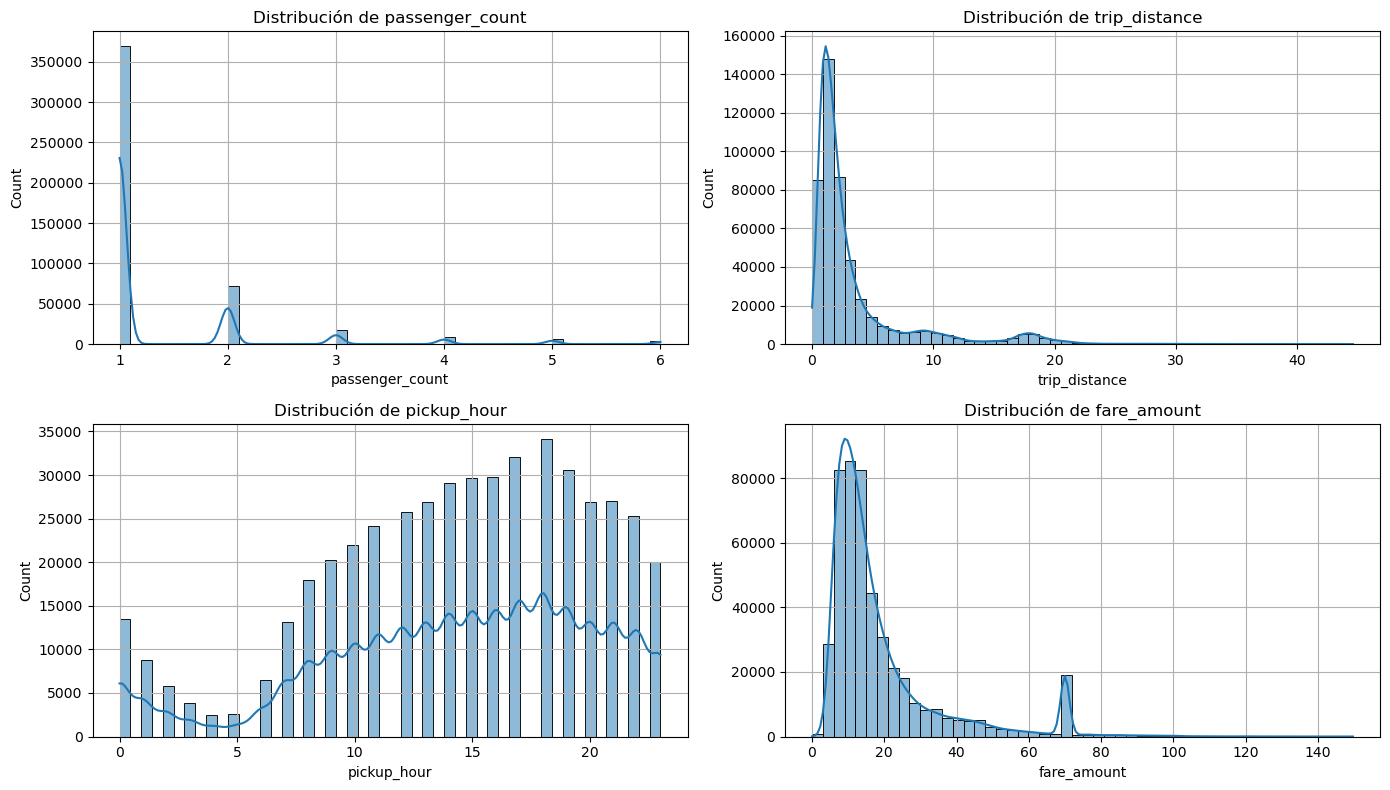

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns


num_vars = ['passenger_count', 'trip_distance', 'pickup_hour', 'fare_amount']

fig, axs = plt.subplots(2, 2, figsize=(14, 8))  # 2x2 grid
axs = axs.flatten()

for i, col in enumerate(num_vars):
    sns.histplot(df[col], kde=True, bins=50, ax=axs[i])
    axs[i].set_title(f'Distribuci√≥n de {col}')
    axs[i].grid(True)

plt.tight_layout()
plt.show()




### 4.2 Countplots

- `RatecodeID`: dominada por categor√≠a 1 (tarifa est√°ndar).
- `PULocationID` y `DOLocationID`: top 20 m√°s frecuentes fueron graficados, y el resto agrupado como ‚Äúotros‚Äù.
- Variables binarias (`is_weekend`, `isnight`, etc.) tienen distribuci√≥n razonable.


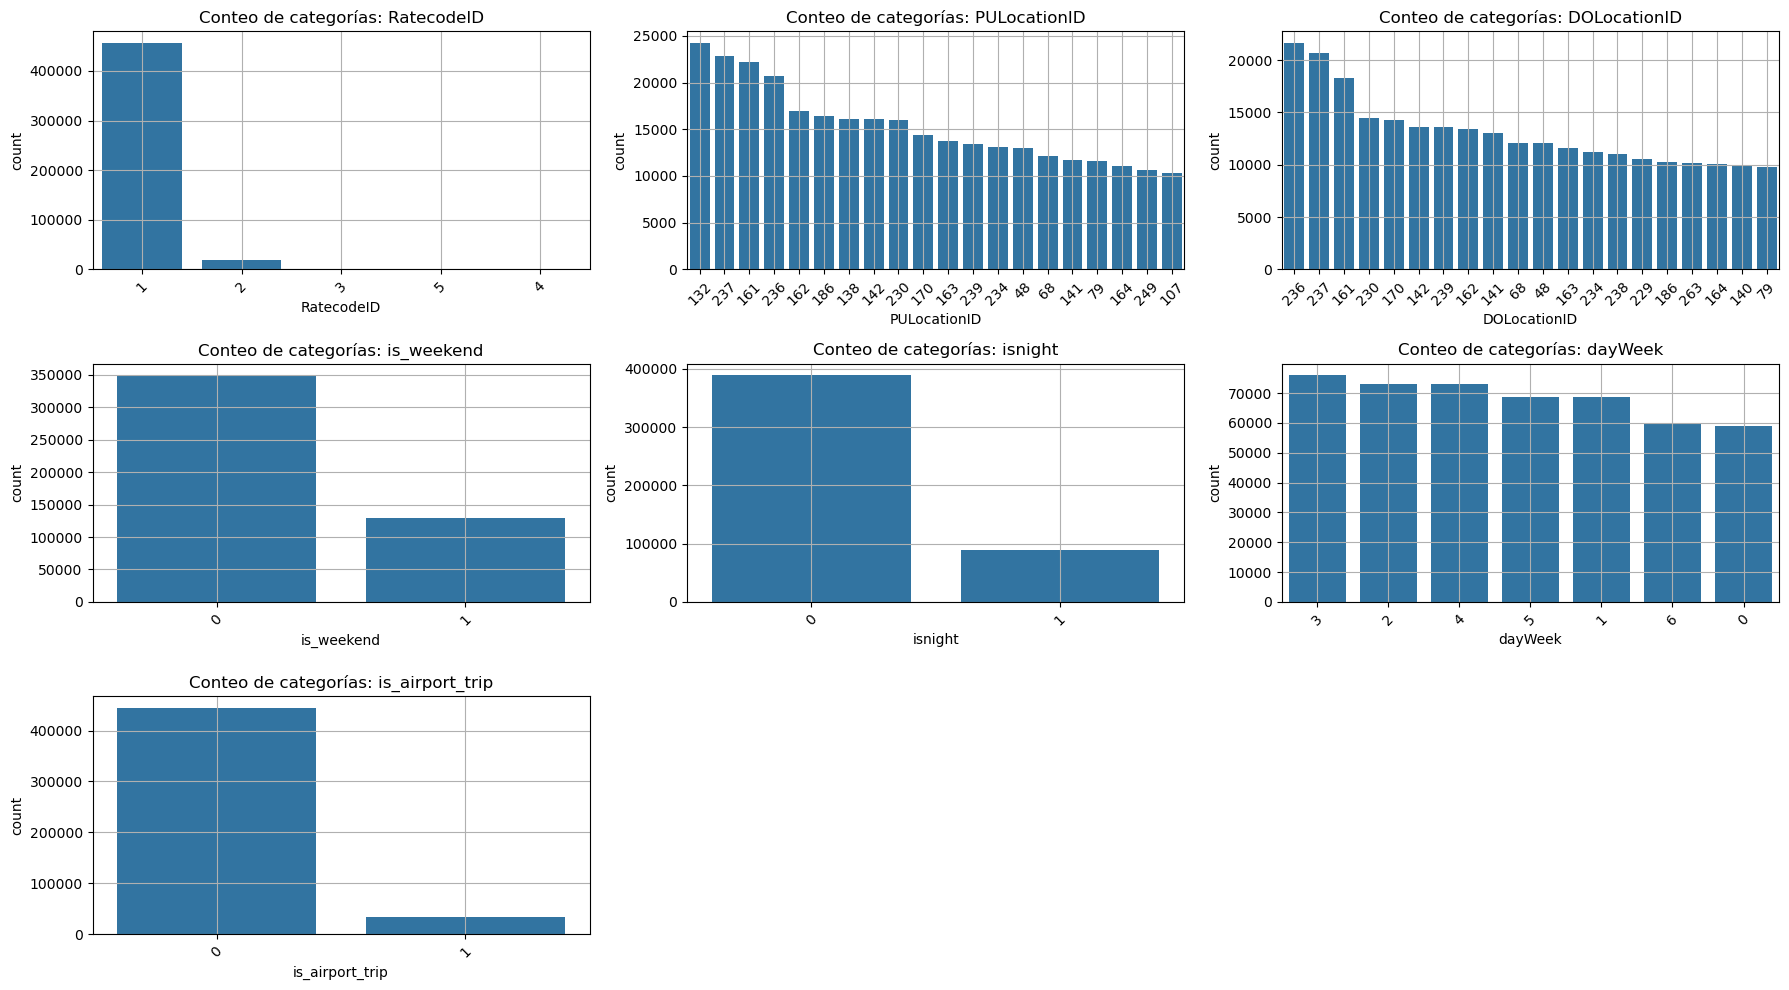

In [14]:
cat_vars = ['RatecodeID', 'PULocationID', 'DOLocationID', 'is_weekend', 'isnight', 'dayWeek', 'is_airport_trip']

fig, axs = plt.subplots(3, 3, figsize=(18, 10))
axs = axs.flatten()

for i, col in enumerate(cat_vars):
    sns.countplot(x=col, data=df, order=df[col].value_counts().index[:20], ax=axs[i])
    axs[i].set_title(f'Conteo de categor√≠as: {col}')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(True)

# Ocultar los ejes vac√≠os si hay m√°s subplots que columnas
for j in range(len(cat_vars), len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


### 4.3 Boxplots

- `fare_amount` es m√°s alto en `RatecodeID` ‚â† 1.
- Los viajes desde `PULocationID` 132 son m√°s caros.
- `is_airport_trip = 1` claramente eleva la tarifa.

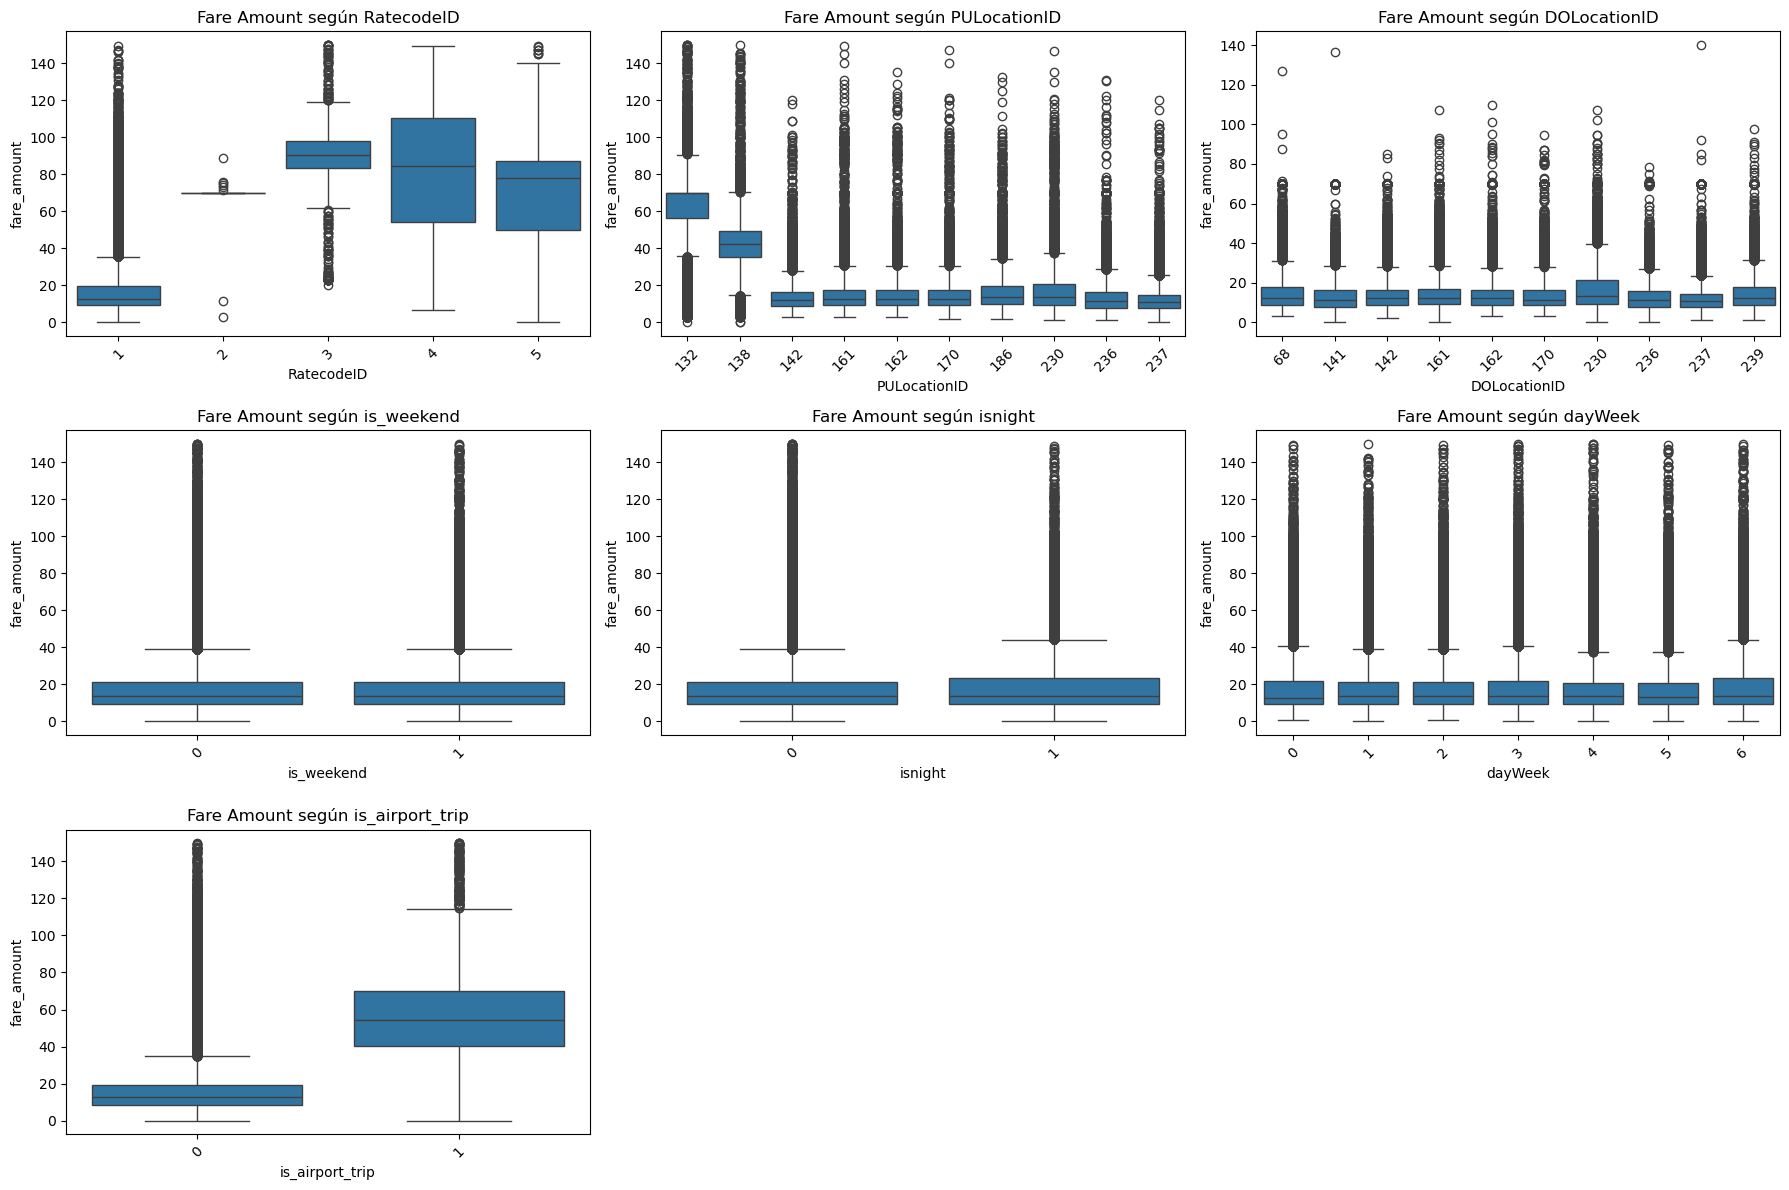

In [15]:

fig, axs = plt.subplots(3, 3, figsize=(18, 12))
axs = axs.flatten()

for i, col in enumerate(cat_vars):
    if df[col].nunique() > 15:
        top_cats = df[col].value_counts().nlargest(10).index
        data_plot = df[df[col].isin(top_cats)]
    else:
        data_plot = df

    sns.boxplot(x=col, y='fare_amount', data=data_plot, ax=axs[i])
    axs[i].set_title(f'Fare Amount seg√∫n {col}')
    axs[i].tick_params(axis='x', rotation=45)

for j in range(len(cat_vars), len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

### 4.4 Scatterplots

- `trip_distance` muestra relaci√≥n lineal con `fare_amount`.
- `passenger_count` y `pickup_hour` no presentan correlaciones fuertes, pero revelan bandas verticales y horizontales esperables.


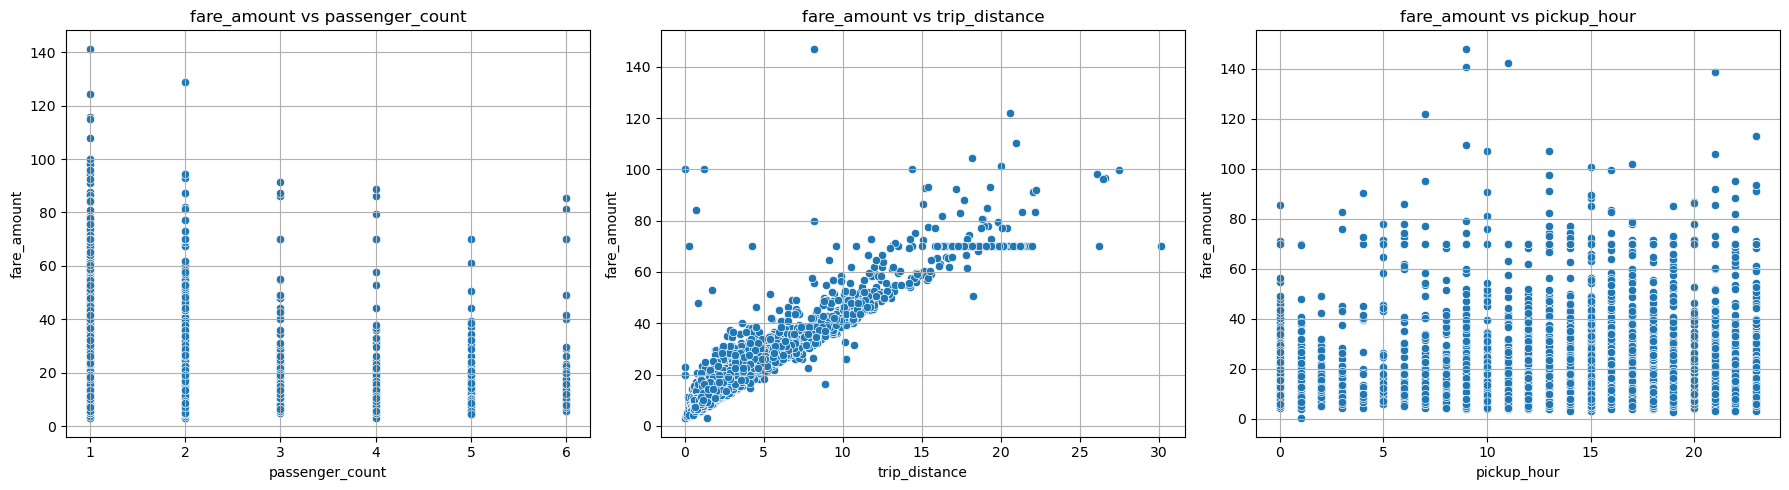

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

num_plot_vars = [col for col in num_vars if col != 'fare_amount']

for i, col in enumerate(num_plot_vars):
    sns.scatterplot(x=col, y='fare_amount', data=df.sample(5000), ax=axs[i])
    axs[i].set_title(f'fare_amount vs {col}')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [17]:
df.describe()

passenger_count  trip_distance     RatecodeID   PULocationID  \
count    478217.000000  478217.000000  478217.000000  478217.000000   
mean          1.378654       3.476166       1.056221     165.867629   
std           0.872847       4.387291       0.300581      63.859807   
min           1.000000       0.010000       1.000000       1.000000   
25%           1.000000       1.100000       1.000000     132.000000   
50%           1.000000       1.830000       1.000000     162.000000   
75%           1.000000       3.450000       1.000000     234.000000   
max           6.000000      44.590000       5.000000     265.000000   

        DOLocationID    fare_amount    pickup_hour     is_weekend  \
count  478217.000000  478217.000000  478217.000000  478217.000000   
mean      164.141998      19.212811      14.317465       0.269328   
std        69.833093      16.703291       5.792475       0.443611   
min         1.000000       0.010000       0.000000       0.000000   
25%       114.000000       9.300000      11.000000       0.000000   
50%       162.000000      13.500000      15.000000       0.000000   
75%       234.000000      21.200001      19.000000       1.000000   
max       265.000000     149.699997      23.000000       1.000000   

             isnight        dayWeek  is_airport_trip  
count  478217.000000  478217.000000    478217.000000  
mean        0.185895       3.007384         0.069583  
std         0.389022       1.921834         0.254444  
min         0.000000       0.000000         0.000000  
25%         0.000000       1.000000         0.000000  
50%         0.000000       3.000000         0.000000  
75%         0.000000       5.000000         0.000000  
max         1.000000       6.000000         1.000000

## 4. Codificaci√≥n y transformaci√≥n de variables categ√≥ricas

Para reducir la dimensionalidad y el ruido de categor√≠as poco frecuentes, se agruparon las 20 ubicaciones m√°s comunes (`PULocationID`, `DOLocationID`) y se agruparon las restantes bajo el nombre `"Otros"`. Luego, se aplic√≥ One-Hot Encoding (`get_dummies`) sobre `RatecodeID`, `PULocationID`, y `DOLocationID`, dejando fuera la primera categor√≠a para evitar multicolinealidad.


In [18]:


# Funci√≥n para agrupar categor√≠as menos frecuentes en "Otros"
def agrupar_top(df, col, top_n=20):
    top_cats = df[col].value_counts().nlargest(top_n).index
    df[col] = df[col].apply(lambda x: x if x in top_cats else 'Otros')
    return df


df = agrupar_top(df, 'PULocationID', top_n=20)
df = agrupar_top(df, 'DOLocationID', top_n=20)


nominales = ['PULocationID', 'DOLocationID', 'RatecodeID']


df_encoded = pd.get_dummies(df, columns=nominales, drop_first=True)



## 5. Transformaci√≥n c√≠clica de variables temporales

Las variables temporales como la hora (`pickup_hour`) y el d√≠a de la semana (`dayWeek`) son c√≠clicas. Para capturar esta naturaleza, se aplicaron funciones seno y coseno, generando nuevas variables:

- `day_sin`, `day_cos` para `dayWeek`
- `hour_sin`, `hour_cos` para `pickup_hour`

Esto permite representar correctamente la cercan√≠a entre valores como la hora 23 y la hora 0.


In [19]:
df_encoded['day_sin'] = np.sin(2 * np.pi * df['dayWeek'] / 7)
df_encoded['day_cos'] = np.cos(2 * np.pi * df['dayWeek'] / 7)


df_encoded['hour_sin'] = np.sin(2 * np.pi * df['pickup_hour'] / 24)
df_encoded['hour_cos'] = np.cos(2 * np.pi * df['pickup_hour'] / 24)

df_encoded.drop(columns=['dayWeek'], inplace=True)
df_encoded.drop(columns=['pickup_hour'], inplace=True)


## 6. Escalamiento y partici√≥n de datos

Se estandarizaron las variables num√©ricas (`passenger_count` y `trip_distance`) con `StandardScaler`, lo que mejora el rendimiento de modelos como la regresi√≥n lineal.  
Luego se dividi√≥ el dataset en conjuntos de entrenamiento (80%) y prueba (20%) para evaluar la generalizaci√≥n del modelo.


In [20]:
num_cols = ['passenger_count', 'trip_distance'] 
X = df_encoded.drop(columns=['fare_amount'])
y = df_encoded['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


## 7. Regresi√≥n Lineal

Se entren√≥ un modelo de regresi√≥n lineal como punto de partida.

**Resultados:**

- **MSE**: 17.909
- **MAE**: 2.456
- **R¬≤**: 0.936

Se obtuvo un rendimiento decente, aunque el gr√°fico de residuos vs. predicciones mostr√≥ cierta estructura, lo que indica que la regresi√≥n lineal no captura completamente las relaciones no lineales.


In [21]:

model = LinearRegression()


model.fit(X_train, y_train)


y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'R2: {r2:.3f}')


MSE: 17.909
MAE: 2.450
R2: 0.936


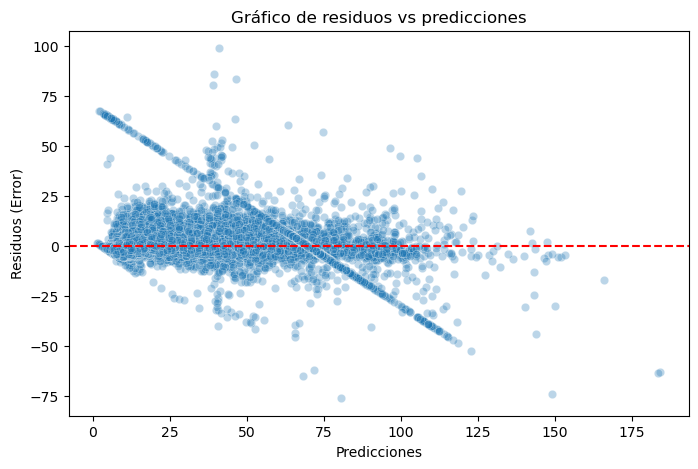

In [22]:

residuos = y_test - y_pred

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=residuos, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuos (Error)')
plt.title('Gr√°fico de residuos vs predicciones')
plt.show()


## 8. Random Forest Regressor

Se utiliz√≥ un modelo no lineal `RandomForestRegressor` para mejorar el desempe√±o.

**Resultados:**

- **MSE**: 9.927
- **MAE**: 1.887
- **R¬≤**: 0.964

El modelo mejor√≥ significativamente en todas las m√©tricas. El gr√°fico de residuos mostr√≥ una dispersi√≥n m√°s homog√©nea y menor sesgo.


In [23]:

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest MSE: {mse_rf:.3f}')
print(f'Random Forest MAE: {mae_rf:.3f}')
print(f'Random Forest R2: {r2_rf:.3f}')


Random Forest MSE: 9.927
Random Forest MAE: 1.887
Random Forest R2: 0.964


## 9. Importancia de variables

El gr√°fico de importancia de caracter√≠sticas del modelo Random Forest muestra que:

- `trip_distance` es, por lejos, la variable m√°s influyente.
- Le siguen algunas dummies de `RatecodeID`, componentes horarios y `passenger_count`.

Esto puede orientar la selecci√≥n de variables en modelos futuros.


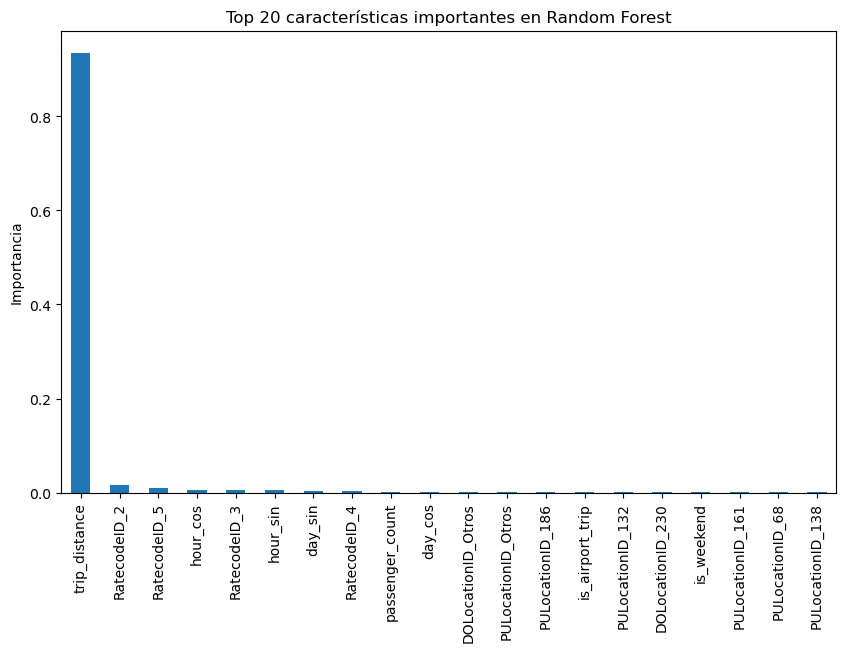

In [24]:

importances = rf.feature_importances_
features = X_train.columns

feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_imp.head(20).plot(kind='bar')
plt.title('Top 20 caracter√≠sticas importantes en Random Forest')
plt.ylabel('Importancia')
plt.show()


## 10. An√°lisis de error absoluto vs. distancia del viaje

Se analiz√≥ c√≥mo var√≠a el error en funci√≥n de la distancia:

- A menor distancia, los errores tienden a concentrarse en valores bajos.
- A mayor distancia, hay m√°s dispersi√≥n y mayor posibilidad de errores altos.
- Se visualiz√≥ esta relaci√≥n con scatterplots y boxplots por rangos de distancia.

Esto es √∫til para entender en qu√© segmentos el modelo es m√°s confiable.

In [25]:
y_pred = y_pred_rf
errors = np.abs(y_test - y_pred)

# Agregamos errores y algunas variables clave a un DataFrame
error_df = X_test.copy()
error_df['fare_amount_real'] = y_test
error_df['fare_amount_pred'] = y_pred
error_df['error'] = errors


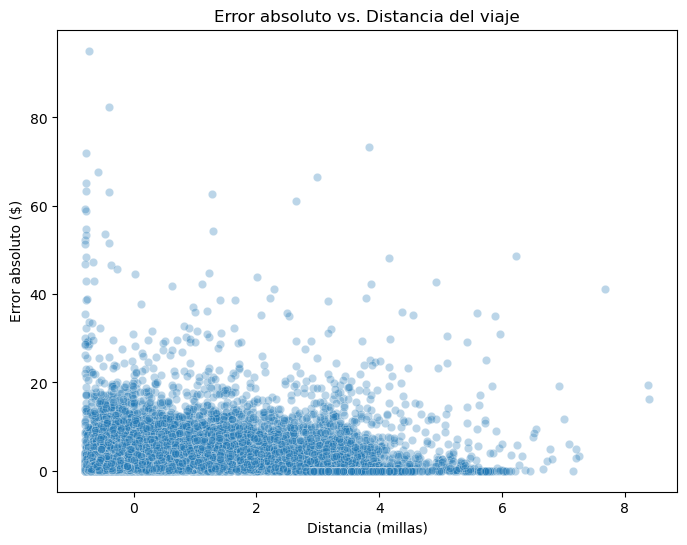

In [26]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=error_df['trip_distance'], y=error_df['error'], alpha=0.3)
plt.title("Error absoluto vs. Distancia del viaje")
plt.xlabel("Distancia (millas)")
plt.ylabel("Error absoluto ($)")
plt.show()


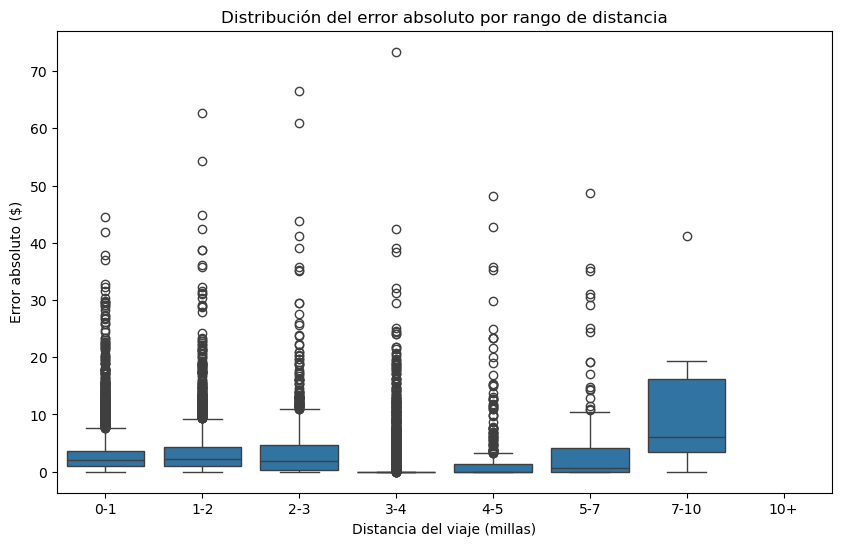

In [27]:
# 1. Calculamos el error absoluto
error_absoluto = np.abs(y_test - y_pred)

# 2. Creamos una copia del set de prueba para graficar
df_error = X_test.copy()
df_error['error_absoluto'] = error_absoluto

# 3. Creamos rangos de distancia (bins)
bins = [0, 1, 2, 3, 4, 5, 7, 10, np.inf]
labels = ['0-1', '1-2', '2-3', '3-4', '4-5', '5-7', '7-10', '10+']
df_error['distancia_bin'] = pd.cut(df_error['trip_distance'], bins=bins, labels=labels)

# 4. Hacemos el boxplot
plt.figure(figsize=(10,6))
sns.boxplot(x='distancia_bin', y='error_absoluto', data=df_error)
plt.title('Distribuci√≥n del error absoluto por rango de distancia')
plt.xlabel('Distancia del viaje (millas)')
plt.ylabel('Error absoluto ($)')
plt.show()

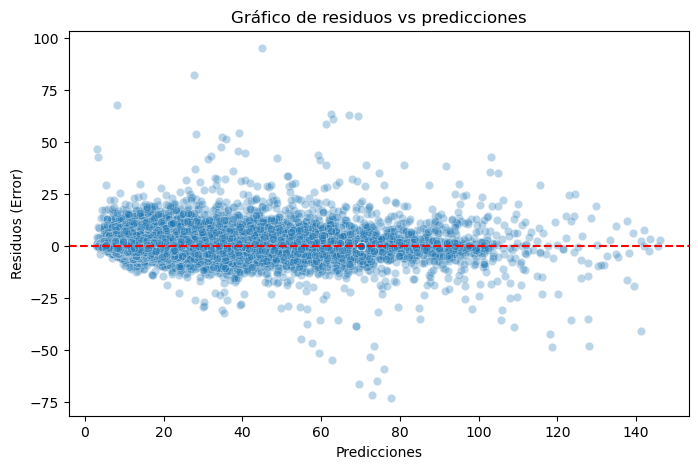

In [28]:


residuos = y_test - y_pred_rf

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_rf, y=residuos, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuos (Error)')
plt.title('Gr√°fico de residuos vs predicciones')
plt.show()





Se aplic√≥ validaci√≥n cruzada de 5 pliegues al modelo Random Forest para validar su robustez.

**Resultados:**

- **R¬≤ promedio CV**: 0.964
- **Desviaci√≥n est√°ndar CV**: 0.001

Esto sugiere que el modelo generaliza bien y tiene buen rendimiento con distintos subconjuntos de datos.


In [29]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, X, y, cv=5, scoring='r2', n_jobs=-1)
 
print(f'R2 promedio CV: {np.mean(scores):.3f}')
print(f'Desviaci√≥n est√°ndar CV: {np.std(scores):.3f}')


R2 promedio CV: 0.964
Desviaci√≥n est√°ndar CV: 0.001


## üßæ Conclusiones Generales del Proyecto

Este proyecto tuvo como objetivo predecir el valor de la tarifa (`fare_amount`) de un viaje en taxi en la ciudad de Nueva York, utilizando datos de pickups registrados en 2023. A trav√©s del pipeline de an√°lisis se aplicaron t√©cnicas modernas de procesamiento, exploraci√≥n, transformaci√≥n de datos y entrenamiento de modelos de machine learning.

### ‚úÖ Principales aprendizajes y hallazgos

- Se realiz√≥ una **limpieza exhaustiva de datos**, eliminando registros con valores imposibles (como tarifas negativas o distancias exageradas).
- Se construyeron nuevas variables relevantes a partir de la informaci√≥n temporal y de contexto, como si era fin de semana, horario nocturno o viaje desde/hacia aeropuerto.
- Se aplicaron **t√©cnicas de ingenier√≠a de variables**, como codificaci√≥n categ√≥rica, agrupaci√≥n de categor√≠as poco frecuentes y transformaci√≥n c√≠clica de variables temporales.
- Se compararon dos modelos: una **Regresi√≥n Lineal** y un **Random Forest**, observando que el segundo tuvo mejor capacidad para capturar relaciones no lineales y reducir el error.
- El **Random Forest obtuvo un R¬≤ de 0.96** y un MAE cercano a 1.9, lo que indica un modelo muy s√≥lido para este tipo de predicci√≥n.
- Se analizaron los errores de predicci√≥n en funci√≥n de la distancia, observando mayor error en viajes largos, lo cual es esperable por su mayor variabilidad.
- Se valid√≥ el modelo mediante **validaci√≥n cruzada**, confirmando su estabilidad y bajo riesgo de sobreajuste.

### üöÄ Pr√≥ximos pasos posibles

- Probar modelos m√°s sofisticados como **Gradient Boosting (XGBoost, LightGBM)**.
- Realizar **selecci√≥n de caracter√≠sticas** o aplicar t√©cnicas de reducci√≥n de dimensionalidad (ej. PCA).
- Experimentar con **segmentaci√≥n de modelos**, por ejemplo, uno para viajes cortos y otro para viajes largos.


